# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>




The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\himateja\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 


filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:27<00:00, 3155.39it/s]


In [23]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

In [24]:
score=final.Score

In [25]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(preprocessed_reviews, score, test_size=0.3, random_state=0,shuffle=False)

In [26]:
from sklearn import preprocessing

# [4] Featurization

## [4.1] BAG OF WORDS

In [27]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 54904)
the number of unique words  54904


## [4.2] Bi-Grams and n-Grams.

In [28]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))

count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(x_train)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])
final_bigram_counts=preprocessing.normalize(final_bigram_counts)
bdata=count_vect.transform(x_test)
bdata=preprocessing.normalize(bdata)

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (61441, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [29]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tdata=tf_idf_vect.fit_transform(x_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)
tdata=preprocessing.normalize(tdata)

tfdata = tf_idf_vect.transform(x_test)
tfdata=preprocessing.normalize(tfdata)
print("the type of count vectorizer ",type(tdata))
print("the shape of out text TFIDF vectorizer ",tdata.get_shape())
print("the number of unique words including both unigrams and bigrams ", tdata.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aafco', 'abandon', 'abdominal', 'ability', 'able', 'able add', 'able buy', 'able chew', 'able drink']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (61441, 36016)
the number of unique words including both unigrams and bigrams  36016


## [4.4] Word2Vec

In [30]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [31]:

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8636060357093811), ('fantastic', 0.8518376350402832), ('terrific', 0.8369103670120239), ('good', 0.8147627115249634), ('excellent', 0.8100983500480652), ('wonderful', 0.7717774510383606), ('amazing', 0.7569868564605713), ('perfect', 0.7361234426498413), ('fabulous', 0.7135833501815796), ('nice', 0.7113245725631714)]
[('greatest', 0.7951724529266357), ('best', 0.7134156823158264), ('tastiest', 0.7073570489883423), ('coolest', 0.674415111541748), ('disgusting', 0.6710941195487976), ('smoothest', 0.6416438817977905), ('closest', 0.6190751194953918), ('horrible', 0.6067203283309937), ('nastiest', 0.5920047760009766), ('terrible', 0.5882911086082458)]


In [32]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  17386
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'infestation', 'literally', 'everywhere', 'flying', 'around', 'kitchen', 'bought', 'hoping', 'least', 'get', 'rid', 'weeks', 'fly', 'stuck', 'squishing', 'buggers', 'success', 'rate']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [33]:
 #average Word2Vec
# compute average word2vec for each review.
def avg(l):
    
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(l): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return np.matrix(sent_vectors)


In [34]:
x_1, x_test, y_1, y_test = train_test_split(list_of_sentance, score, test_size=0.3, random_state=0,shuffle=False)

In [35]:
x_1=avg(x_1)
x_test=avg(x_test)

100%|███████████████████████████████████████████████████████████████████████████| 26332/26332 [00:48<00:00, 541.76it/s]


In [36]:
#changing nan values if any
atrain=np.nan_to_num(x_1)
atest=np.nan_to_num(x_test)

#### [4.4.1.2] TFIDF weighted W2v

In [37]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [38]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

def tw2v(l,d,t=tfidf_feat):
    tfidf_sent_vectors = [] # the tfidf-w2v for each sentence/review is stored in this list
    row=0
    for sent in tqdm(l): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in t:
                vec = w2v_model.wv[word]
                tf_idf = tf_idf_matrix[row, t.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = d[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return np.matrix(tfidf_sent_vectors)

In [39]:
x_1=tw2v(x_1,dictionary)
x_test=tw2v(x_test,dictionary)

100%|████████████████████████████████████████████████████████████████████████████| 26332/26332 [13:39<00:00, 32.14it/s]


In [40]:
# changing 'NaN' to numeric value
train=np.nan_to_num(x_1)
test=np.nan_to_num(x_test)

In [48]:
from sklearn.ensemble import RandomForestClassifier
#importing needed 
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score as roc
import random
from sklearn.model_selection import RandomizedSearchCV
import scipy
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

In [170]:
#function for finding optimal parameters
def clfg(xtrain,ytrain,xtest,ytest):

    #using the gridsearchcv for finding the best c
    rf = RandomForestClassifier()
    n_estimators=[10,50,60,80,100,125,150]
    max_depth=[5,7,9,11,13,15,17]
    param_grid = {'n_estimators':[10,50,60,80,100,125,150],'max_depth':[5,7,9,11,13,15,17]} 
    #For time based splitting
    t = TimeSeriesSplit(n_splits=3) 

    gsv = GridSearchCV(rf,param_grid,cv=t,n_jobs=-1,verbose=1,scoring="roc_auc")
    gsv.fit(xtrain,ytrain)
    print("Best HyperParameter: ",gsv.best_params_)
    #assinging best alpha to optimal print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))
    print("best estimator: ",gsv.estimator)
    #print("cv results :",gsv.cv_results_)
    
    es=gsv.best_params_['n_estimators']
    md=gsv.best_params_['max_depth']
    
    
    rf=RandomForestClassifier(n_estimators=es,max_depth=md)
    rf.fit(xtrain,ytrain)
    pred=rf.predict(xtest)
    #different metrics
    acc=accuracy_score(y_test,pred)*100
    print("\nthe accuracy is %.2f%%"%acc)

    re=recall_score(y_test,pred,) * 100
    print("\nthe recall is %.2f%%"%re)

    pre=precision_score(y_test,pred) * 100
    print("the precision is %.2f%%"%pre)

    f1=f1_score(y_test,pred) * 100
    print("the f1 score is %.2f%%"%f1)

    df_cm=pd.DataFrame(confusion_matrix(y_test,pred))
    #sns.set(font_scale=1.4)
    sns.heatmap(df_cm,annot=True,fmt="d")
    
    print('\n\n')
    plt.figure(figsize=(8, 6))
    scores = gsv.cv_results_['mean_test_score'].reshape(len(n_estimators),len(max_depth))
    testing = sns.heatmap(scores, annot=True)

    plt.xlabel('n_estimators')
    plt.ylabel('max_depth')

    plt.xticks(np.arange(len(n_estimators)), n_estimators, rotation=45)
    plt.yticks(np.arange(len(max_depth)), max_depth)
    plt.title('Cross Validation accuracy')
    plt.show()
    

    

## [5.1] Applying RF

### [5.1.1] Applying Random Forests on BOW

In [171]:
# Please write all the code with proper documentation

Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:  1.8min finished


Best HyperParameter:  {'max_depth': 17, 'n_estimators': 100}
best estimator:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

the accuracy is 83.35%

the recall is 100.00%
the precision is 83.26%
the f1 score is 90.86%





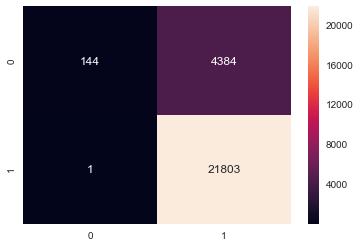

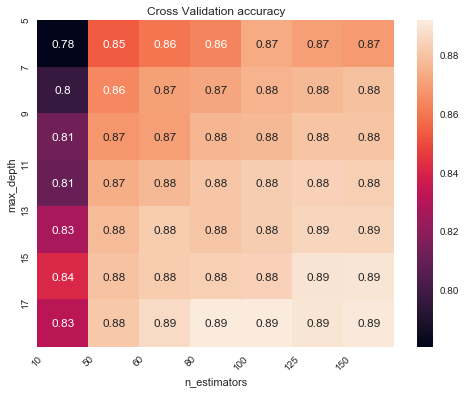

Wall time: 2min 6s


In [172]:
%%time
clfg(final_bigram_counts,y_train,bdata,y_test)

### [5.1.2] Wordcloud of top 20 important features 

In [173]:
# Please write all the code with proper documentation

In [174]:
rrf=RandomForestClassifier(n_estimators=150,max_depth=15)
rrf.fit(final_bigram_counts,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [175]:
all_feat=count_vect.get_feature_names()

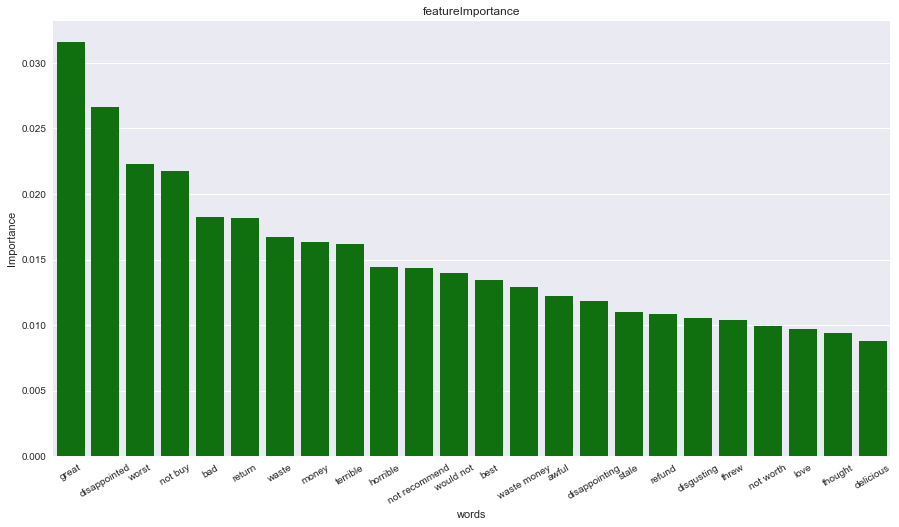

In [176]:
imp_features = rrf.feature_importances_
    
# sorting the weight indices 
imp_sorted =  np.argsort(imp_features)[::-1]

# top features
imp = np.take(all_feat, imp_sorted[1:25])
val = np.take(imp_features, imp_sorted[1:25])
#plotting       
sns.set()
plt.figure(figsize=(15, 8))
imp_plot = sns.barplot(imp, val, color="green")
imp_plot.set_xticklabels(imp, rotation=30)
plt.ylabel('Importance')
plt.xlabel('words') 
plt.title('featureImportance')
plt.show()

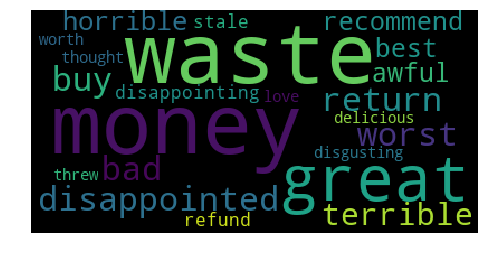

In [177]:
#wordcloud formation
from wordcloud import WordCloud,STOPWORDS
impo=list(imp)
imp_text=" ".join(impo)
cloud=WordCloud().generate(imp_text)
plt.figure(figsize=(8,8))
plt.imshow(cloud)
plt.grid(False)
plt.axis('off')
plt.show()

The model performed decent.

### [5.1.3] Applying Random Forests on TFIDF

In [178]:
# Please write all the code with proper documentation

Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:  2.2min finished


Best HyperParameter:  {'max_depth': 17, 'n_estimators': 125}
best estimator:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

the accuracy is 82.83%

the recall is 100.00%
the precision is 82.82%
the f1 score is 90.60%





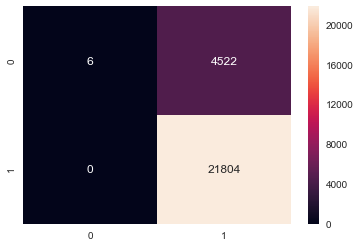

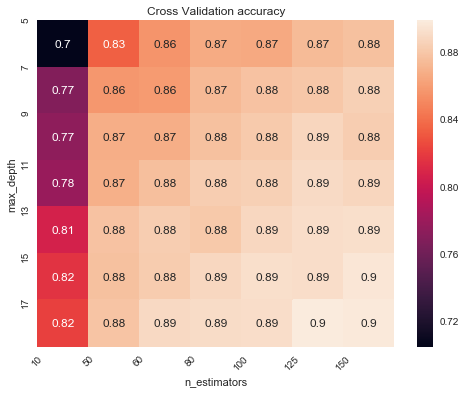

Wall time: 2min 23s


In [180]:
%%time
clfg(tdata,y_train,tfdata,y_test)

### [5.1.4] Wordcloud of top 20 important features

In [0]:
# Please write all the code with proper documentation

In [181]:
rrf=RandomForestClassifier(n_estimators=125,max_depth=15)
rrf.fit(tdata,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=125, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

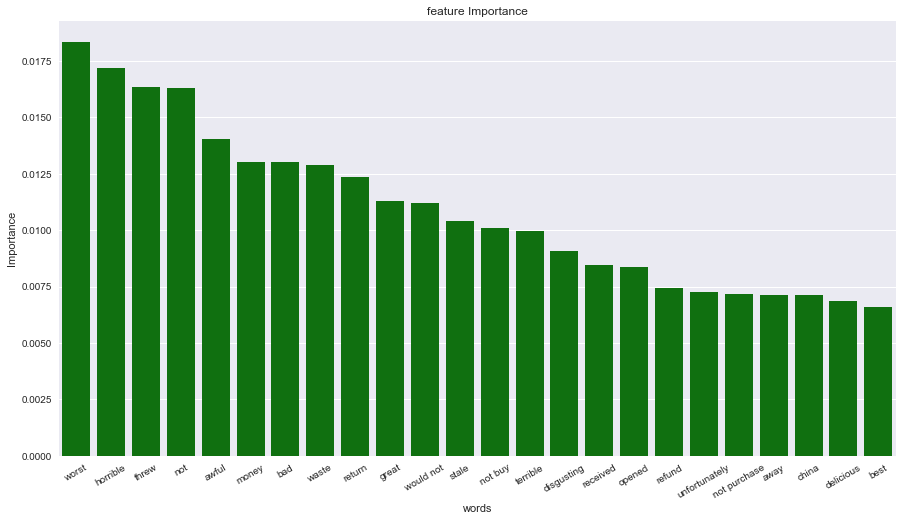

In [183]:
all_feat=tf_idf_vect.get_feature_names()
imp_features = rrf.feature_importances_
    
# sorting the weight indices 
imp_sorted =  np.argsort(imp_features)[::-1]

# top features
imp = np.take(all_feat, imp_sorted[1:25])
val = np.take(imp_features, imp_sorted[1:25])
        
# plotting
sns.set()
plt.figure(figsize=(15, 8))
imp_plot = sns.barplot(imp, val, color="green")
imp_plot.set_xticklabels(imp, rotation=30)
plt.ylabel('Importance')
plt.xlabel('words') 
plt.title('feature Importance')
plt.show()

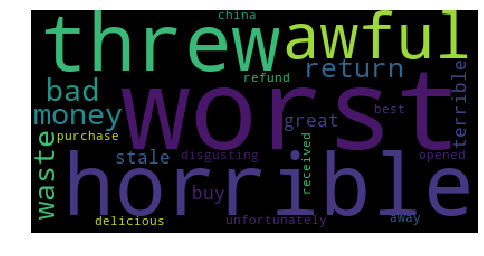

In [184]:
#forming wordcloud
impo=list(imp)
imp_text=" ".join(impo)
cloud=WordCloud().generate(imp_text)
plt.figure(figsize=(8,8))
plt.imshow(cloud)
plt.grid(False)
plt.axis('off')
plt.show()

The model performs decent.

### [5.1.5] Applying Random Forests on AVG W2V

In [185]:
# Please write all the code with proper documentation

Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:  7.3min finished


Best HyperParameter:  {'max_depth': 11, 'n_estimators': 150}
best estimator:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

the accuracy is 86.88%

the recall is 98.68%
the precision is 87.17%
the f1 score is 92.57%





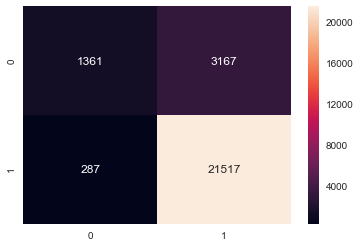

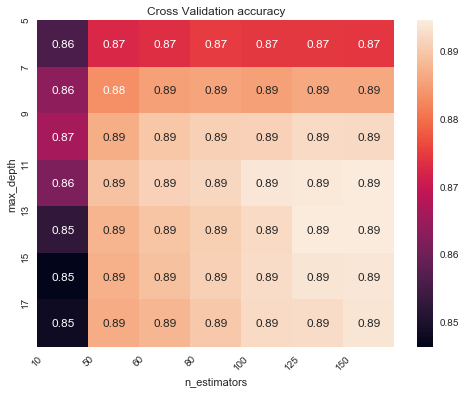

Wall time: 8min 50s


In [186]:
%%time
clfg(atrain,y_1,atest,y_test)

The model here performs better than models on BOW and TFIDF

### [5.1.6] Applying Random Forests on TFIDF W2V

In [187]:
# Please write all the code with proper documentation

Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:  1.6min finished


Best HyperParameter:  {'max_depth': 5, 'n_estimators': 10}
best estimator:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

the accuracy is 82.80%

the recall is 100.00%
the precision is 82.80%
the f1 score is 90.59%





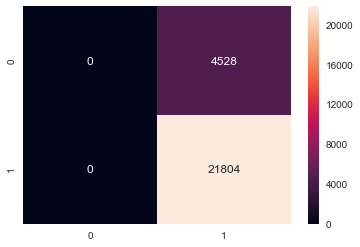

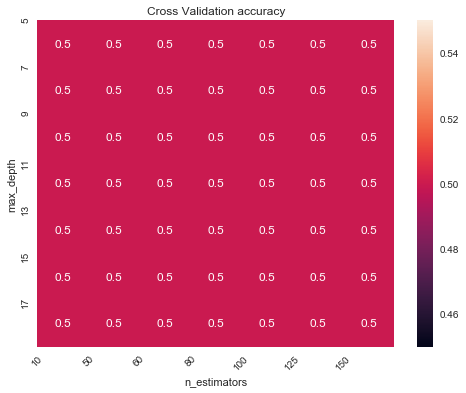

Wall time: 1min 36s


In [188]:
%%time
clfg(train,y_1,test,y_test)

This model is a dumb model.

## [5.2] Applying GBDT using XGBOOST

In [44]:
from xgboost import XGBClassifier

In [49]:
#function for finding optimal parameters
def xclfg(xtrain,ytrain,xtest,ytest):

    #using the gridsearchcv for finding the best c
    xc = XGBClassifier()
    n_estimators=[50,60,80,100,125,150]
    max_depth=[3,5,7,9,11,13]
    param_grid = {'n_estimators':[50,60,80,100,125,150],'max_depth':[3,5,7,9,11,13]} 
    #For time based splitting
    t = TimeSeriesSplit(n_splits=3) 

    gsv = GridSearchCV(xc,param_grid,cv=t,n_jobs=-1,verbose=1,scoring="roc_auc")
    gsv.fit(xtrain,ytrain)
    print("Best HyperParameter: ",gsv.best_params_)
    #assinging best alpha to optimal print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))
    print("best estimator: ",gsv.estimator)
    #print("cv results :",gsv.cv_results_)
    
    es=gsv.best_params_['n_estimators']
    md=gsv.best_params_['max_depth']
    
    
    xc=XGBClassifier(n_estimators=es,max_depth=md)
    xc.fit(xtrain,ytrain)
    pred=xc.predict(xtest)
    #different metrics
    acc=accuracy_score(y_test,pred)*100
    print("\nthe accuracy is %.2f%%"%acc)

    re=recall_score(y_test,pred,) * 100
    print("\nthe recall is %.2f%%"%re)

    pre=precision_score(y_test,pred) * 100
    print("the precision is %.2f%%"%pre)

    f1=f1_score(y_test,pred) * 100
    print("the f1 score is %.2f%%"%f1)

    df_cm=pd.DataFrame(confusion_matrix(y_test,pred))
    #sns.set(font_scale=1.4)
    sns.heatmap(df_cm,annot=True,fmt="d")
    
    print('\n\n')
    plt.figure(figsize=(8, 6))
    scores = gsv.cv_results_['mean_test_score'].reshape(len(n_estimators),len(max_depth))
    testing = sns.heatmap(scores, annot=True)

    plt.xlabel('n_estimators')
    plt.ylabel('max_depth')

    plt.xticks(np.arange(len(n_estimators)), n_estimators, rotation=45)
    plt.yticks(np.arange(len(max_depth)), max_depth)
    plt.title('Cross Validation accuracy')
    plt.show()
    

### [5.2.1] Applying XGBOOST on BOW

In [50]:
# Please write all the code with proper documentation

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 19.5min finished


Best HyperParameter:  {'max_depth': 13, 'n_estimators': 150}
best estimator:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


C:\Users\himateja\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



the accuracy is 90.79%

the recall is 98.27%
the precision is 91.28%
the f1 score is 94.65%





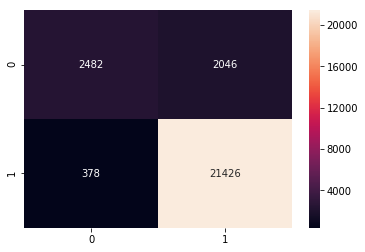

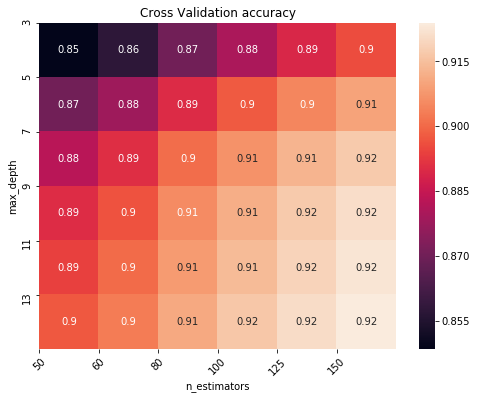

Wall time: 24min 34s


In [51]:
%%time
xclfg(final_bigram_counts,y_train,bdata,y_test)

The XGBoost model performs better than Random forest for BOW.

### [5.2.2] Applying XGBOOST on TFIDF

In [52]:
# Please write all the code with proper documentation

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 50.5min finished


Best HyperParameter:  {'max_depth': 13, 'n_estimators': 150}
best estimator:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


C:\Users\himateja\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



the accuracy is 91.04%

the recall is 98.32%
the precision is 91.50%
the f1 score is 94.78%





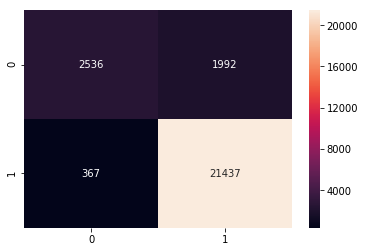

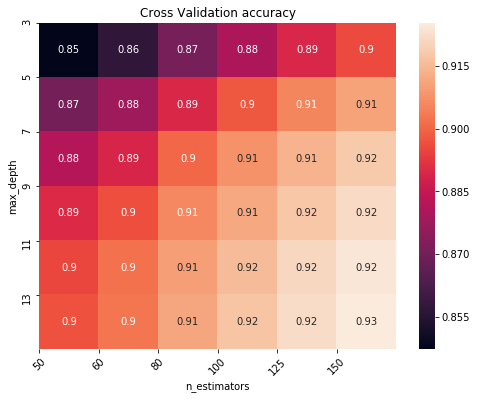

Wall time: 59min 7s


In [53]:
%%time
xclfg(tdata,y_train,tfdata,y_test)

The XGBoost model performs better than Random forest on TFIDF

### [5.2.3] Applying XGBOOST on AVG W2V

In [54]:
# Please write all the code with proper documentation

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 20.3min finished


Best HyperParameter:  {'max_depth': 13, 'n_estimators': 150}
best estimator:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


C:\Users\himateja\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



the accuracy is 88.64%

the recall is 96.55%
the precision is 90.39%
the f1 score is 93.37%





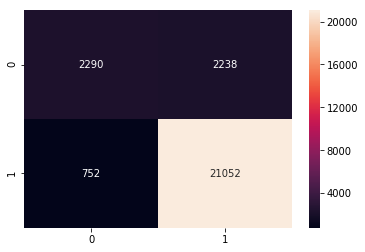

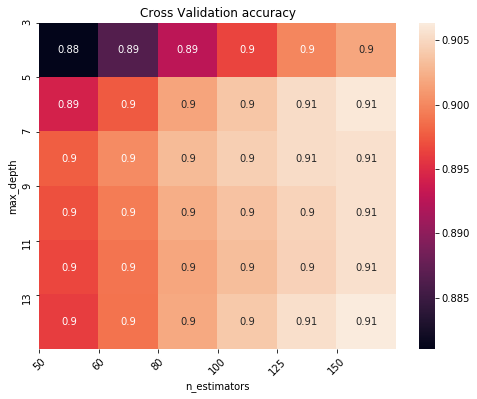

Wall time: 26min 6s


In [55]:
%%time
xclfg(atrain,y_1,atest,y_test)

The performance of the model is good.

### [5.2.4] Applying XGBOOST on TFIDF W2V

In [0]:
# Please write all the code with proper documentation

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  3.3min finished


Best HyperParameter:  {'max_depth': 3, 'n_estimators': 50}
best estimator:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


C:\Users\himateja\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



the accuracy is 82.80%

the recall is 100.00%
the precision is 82.80%
the f1 score is 90.59%





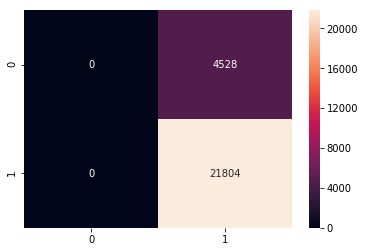

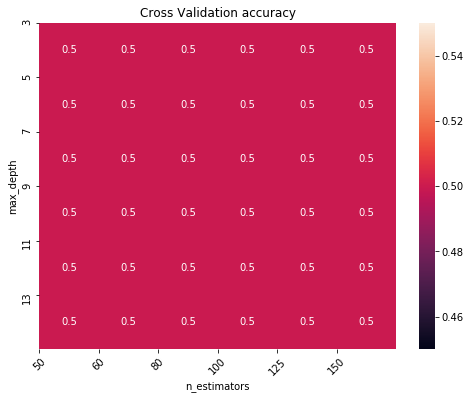

Wall time: 3min 24s


In [56]:
%%time
xclfg(train,y_1,test,y_test)

This model is a dumb model.

# [6] Conclusions

In [58]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable

Random Forest

In [67]:
x=PrettyTable()

In [68]:
x.field_names = ['feature_set','n_estimators','max_depth','ROC']

In [69]:
x.add_row(["BOW",'100','17','83.35%'])
x.add_row(["TFIDF",'125','17','82.35%'])
x.add_row(["AVG_W2v",'150','11','86.88%'])
x.add_row(["TFIDF_w2V",'10','5','82.80%'])

In [70]:
print(x)

+-------------+--------------+-----------+--------+
| feature_set | n_estimators | max_depth |  ROC   |
+-------------+--------------+-----------+--------+
|     BOW     |     100      |     17    | 83.35% |
|    TFIDF    |     125      |     17    | 82.35% |
|   AVG_W2v   |     150      |     11    | 86.88% |
|  TFIDF_w2V  |      10      |     5     | 82.80% |
+-------------+--------------+-----------+--------+


XGBoost

In [71]:
y=PrettyTable()

In [72]:
y.field_names = ['feature_set','n_estimators','max_depth','ROC']

In [73]:
y.add_row(["BOW",'150','13','90.79%'])
y.add_row(["TFIDF",'150','13','91.04%'])
y.add_row(["AVG_W2v",'150','13','86.64%'])
y.add_row(["TFIDF_w2V",'50','3','82.80%'])

In [74]:
print(y)

+-------------+--------------+-----------+--------+
| feature_set | n_estimators | max_depth |  ROC   |
+-------------+--------------+-----------+--------+
|     BOW     |     150      |     13    | 90.79% |
|    TFIDF    |     150      |     13    | 91.04% |
|   AVG_W2v   |     150      |     13    | 86.64% |
|  TFIDF_w2V  |      50      |     3     | 82.80% |
+-------------+--------------+-----------+--------+
